In [39]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [14]:
BATCH_SIZE = 32
OUT = 3
INPUT_SHAPE = (35,35,3)
EPOCHS = 10

In [15]:
def plot_learning_metrics(result, title):
    accuracy_percentage = np.round(100 * result.history["accuracy"][-1], 3) 
    print(f"Accuracy: {accuracy_percentage}% \n")
    
    x_range = range(EPOCHS)
    
    fig, (loss_plt, accuracy_plt) = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
    
    loss_plt.plot(x_range, result.history["loss"], "r", label="TRAIN loss")
    loss_plt.plot(x_range, result.history["val_loss"], "g", label="TEST loss")
    loss_plt.legend()
    
    accuracy_plt.plot(x_range, result.history["accuracy"], "b", label="TRAIN accuracy")
    accuracy_plt.plot(x_range, result.history["val_accuracy"], "lightgreen", label="TEST accuracy")
    accuracy_plt.legend()
    
    plt.suptitle(f"TRAIN and TEST metrics -> {title}")
    
    fig.tight_layout()
    plt.show()

# Mask detection

In [16]:
datagen = ImageDataGenerator(
    rescale = 1.0 / 255, 
    horizontal_flip=True, 
    zoom_range=0.1, 
    shear_range=0.2, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    rotation_range=4, 
    vertical_flip=False
)

val_datagen = ImageDataGenerator(
    rescale = 1.0 / 255
)

In [17]:
train_dataset = datagen.flow_from_directory(
    directory="./mask_dataset/train",
    target_size=(35, 35),
    class_mode="categorical",
    batch_size = BATCH_SIZE,
    shuffle = True
)

validation_dataset = val_datagen.flow_from_directory(
    directory = "./mask_dataset/val",
    target_size = (35, 35),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle=True
)

test_dataset = val_datagen.flow_from_directory(
    directory = "./mask_dataset/test",
    target_size = (35, 35),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True
)

Found 3876 images belonging to 3 classes.
Found 1036 images belonging to 3 classes.
Found 465 images belonging to 3 classes.


In [18]:
data_size = len(train_dataset)
steps_per_epoch = data_size // BATCH_SIZE
validation_steps = len(validation_dataset) // BATCH_SIZE

print(f" steps per epoch: {steps_per_epoch}, validation steps: {validation_steps}")

 steps per epoch: 3, validation steps: 1


#### Model with one convolutional layer

In [143]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(35, kernel_size=(3, 3), activation="relu", padding="same", input_shape=INPUT_SHAPE),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUT, activation="softmax")
])

model.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
             optimizer = tf.optimizers.Adam(),
             metrics = ["accuracy"])

model.summary()

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_255 (Conv2D)         (None, 35, 35, 35)        980       
                                                                 
 flatten_66 (Flatten)        (None, 42875)             0         
                                                                 
 dense_66 (Dense)            (None, 3)                 128628    
                                                                 
Total params: 129,608
Trainable params: 129,608
Non-trainable params: 0
_________________________________________________________________


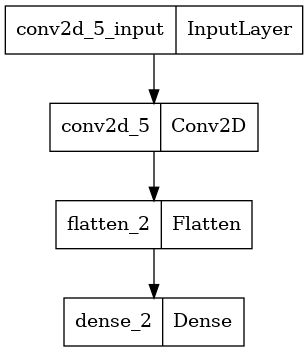

In [20]:
tf.keras.utils.plot_model(model)

Epoch 1/10
122/122 [==============================] - 3s 22ms/step - loss: 0.3436 - accuracy: 0.8911 - val_loss: 0.1898 - val_accuracy: 0.9450
Epoch 2/10
122/122 [==============================] - 3s 24ms/step - loss: 0.2398 - accuracy: 0.9288 - val_loss: 0.1695 - val_accuracy: 0.9517
Epoch 3/10
122/122 [==============================] - 3s 24ms/step - loss: 0.2237 - accuracy: 0.9340 - val_loss: 0.1620 - val_accuracy: 0.9546
Epoch 4/10
122/122 [==============================] - 3s 24ms/step - loss: 0.2138 - accuracy: 0.9365 - val_loss: 0.1549 - val_accuracy: 0.9527
Epoch 5/10
122/122 [==============================] - 3s 26ms/step - loss: 0.2069 - accuracy: 0.9399 - val_loss: 0.1678 - val_accuracy: 0.9488
Epoch 6/10
122/122 [==============================] - 4s 31ms/step - loss: 0.2070 - accuracy: 0.9360 - val_loss: 0.1667 - val_accuracy: 0.9575
Epoch 7/10
122/122 [==============================] - 4s 33ms/step - loss: 0.1982 - accuracy: 0.9381 - val_loss: 0.1244 - val_accuracy: 0.9624

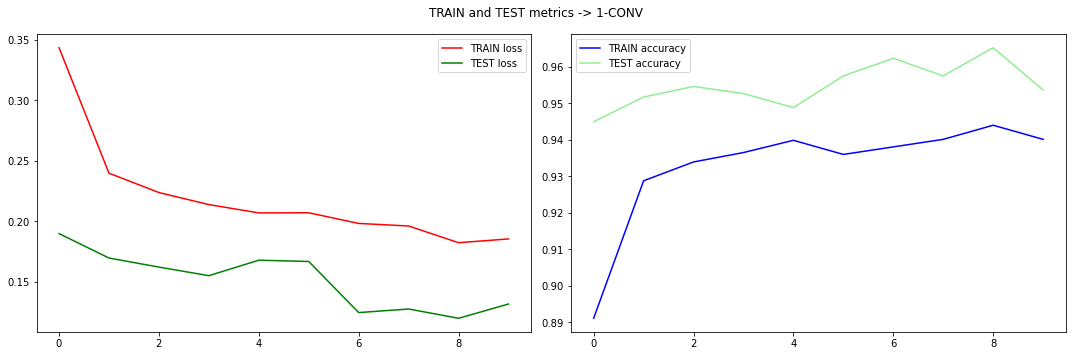

In [74]:
result = model.fit(train_dataset, 
                   validation_data=validation_dataset, 
                   epochs=EPOCHS, 
                   batch_size=BATCH_SIZE, 
                   verbose=True)
plot_learning_metrics(result, "1-CONV")

In [22]:
_, accuracy = model.evaluate(test_dataset, verbose=False)
print(f"SIMPLE CONV\nTEST accuracy: {accuracy}")

SIMPLE CONV
TEST accuracy: 0.9612902998924255


#### Model with several convolutional layers
Including dropout, mini-batch normaization. Must include different numbers of convolutional layers and parameters values.

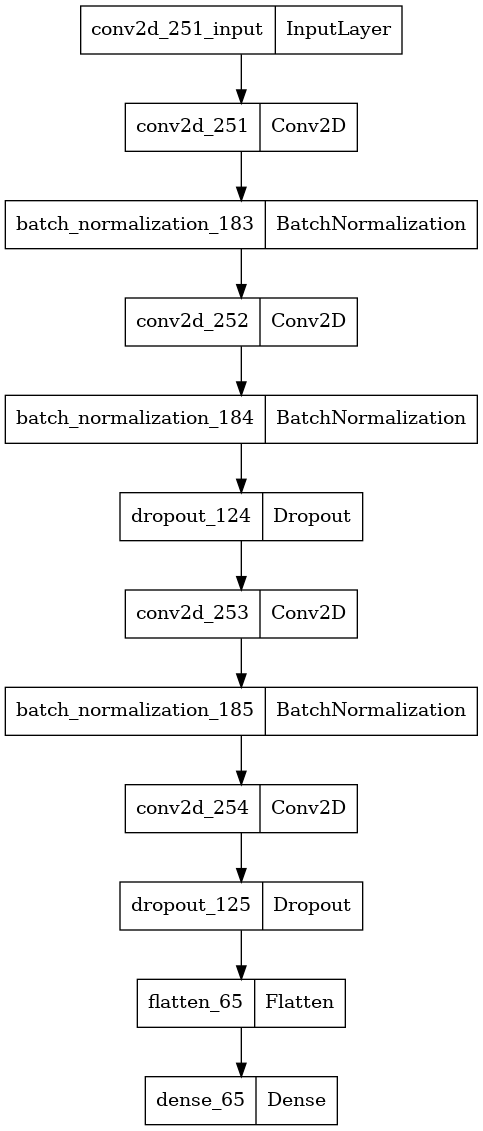

In [118]:
advanced_model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", input_shape=INPUT_SHAPE),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides = 2, padding="same", activation="relu"),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUT, activation="softmax")
])

advanced_model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                         optimizer=tf.keras.optimizers.Adam(), 
                         metrics=["accuracy"])

tf.keras.utils.plot_model(advanced_model_1)

In [144]:
advanced_model_1.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_251 (Conv2D)         (None, 35, 35, 32)        896       
                                                                 
 batch_normalization_183 (Ba  (None, 35, 35, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_252 (Conv2D)         (None, 18, 18, 32)        9248      
                                                                 
 batch_normalization_184 (Ba  (None, 18, 18, 32)       128       
 tchNormalization)                                               
                                                                 
 dropout_124 (Dropout)       (None, 18, 18, 32)        0         
                                                                 
 conv2d_253 (Conv2D)         (None, 9, 9, 64)        

In [119]:
result = advanced_model_1.fit(train_dataset, 
                              validation_data=validation_dataset, 
                              epochs=EPOCHS, 
                              batch_size=BATCH_SIZE)

Epoch 1/10
122/122 [==============================] - 4s 28ms/step - loss: 0.3649 - accuracy: 0.8847 - val_loss: 0.4174 - val_accuracy: 0.8089
Epoch 2/10
122/122 [==============================] - 3s 28ms/step - loss: 0.2541 - accuracy: 0.9218 - val_loss: 0.3894 - val_accuracy: 0.8542
Epoch 3/10
122/122 [==============================] - 3s 27ms/step - loss: 0.2371 - accuracy: 0.9275 - val_loss: 0.2431 - val_accuracy: 0.9044
Epoch 4/10
122/122 [==============================] - 4s 35ms/step - loss: 0.2373 - accuracy: 0.9249 - val_loss: 0.2013 - val_accuracy: 0.9266
Epoch 5/10
122/122 [==============================] - 5s 39ms/step - loss: 0.2160 - accuracy: 0.9368 - val_loss: 0.1832 - val_accuracy: 0.9392
Epoch 6/10
122/122 [==============================] - 5s 42ms/step - loss: 0.2066 - accuracy: 0.9381 - val_loss: 0.1950 - val_accuracy: 0.9344
Epoch 7/10
122/122 [==============================] - 5s 40ms/step - loss: 0.1982 - accuracy: 0.9381 - val_loss: 0.1097 - val_accuracy: 0.9653

SIMPLE CONV
TEST accuracy: 0.9548386931419373
Accuracy: 94.221% 



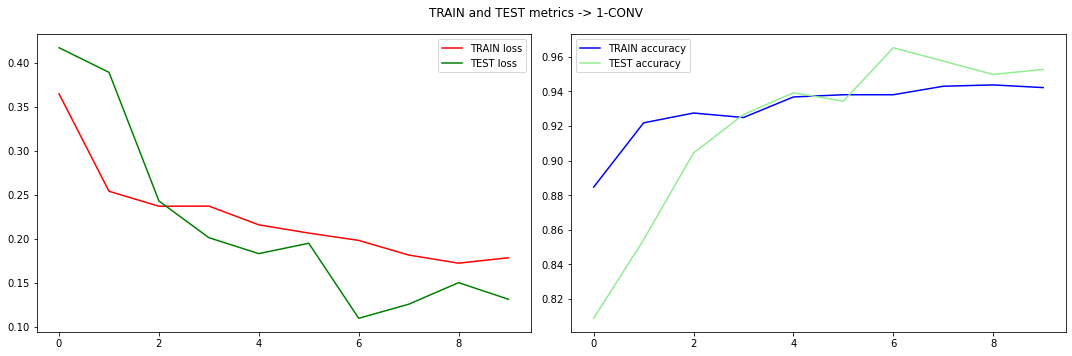

In [120]:
_, accuracy = advanced_model_1.evaluate(test_dataset, verbose=False)
print(f"SIMPLE CONV\nTEST accuracy: {accuracy}")
plot_learning_metrics(result, "1-CONV")

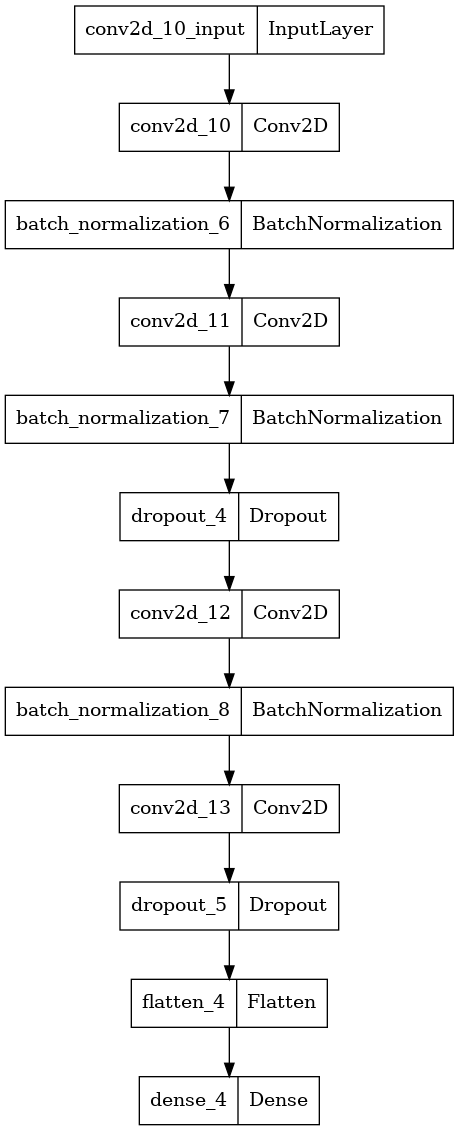

In [26]:
advanced_model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", input_shape=INPUT_SHAPE),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=3, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=3, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides = 3, padding="same", activation="relu"),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUT, activation="softmax")
])

advanced_model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                         optimizer=tf.keras.optimizers.Adam(), 
                         metrics=["accuracy"])

tf.keras.utils.plot_model(advanced_model_2)

In [27]:
result = advanced_model_2.fit(train_dataset, 
                              validation_data=validation_dataset, 
                              epochs=EPOCHS, 
                              batch_size=BATCH_SIZE)

Epoch 1/10
122/122 [==============================] - 6s 43ms/step - loss: 0.3304 - accuracy: 0.8919 - val_loss: 0.7740 - val_accuracy: 0.7278
Epoch 2/10
122/122 [==============================] - 5s 42ms/step - loss: 0.2316 - accuracy: 0.9334 - val_loss: 0.3260 - val_accuracy: 0.8832
Epoch 3/10
122/122 [==============================] - 5s 44ms/step - loss: 0.2187 - accuracy: 0.9303 - val_loss: 0.2782 - val_accuracy: 0.9266
Epoch 4/10
122/122 [==============================] - 5s 42ms/step - loss: 0.2109 - accuracy: 0.9365 - val_loss: 0.1765 - val_accuracy: 0.9373
Epoch 5/10
122/122 [==============================] - 5s 40ms/step - loss: 0.1916 - accuracy: 0.9420 - val_loss: 0.1160 - val_accuracy: 0.9595
Epoch 6/10
122/122 [==============================] - 5s 39ms/step - loss: 0.1917 - accuracy: 0.9404 - val_loss: 0.1102 - val_accuracy: 0.9662
Epoch 7/10
122/122 [==============================] - 5s 39ms/step - loss: 0.1899 - accuracy: 0.9422 - val_loss: 0.1168 - val_accuracy: 0.9614

SIMPLE CONV
TEST accuracy: 0.9677419066429138
Accuracy: 94.195% 



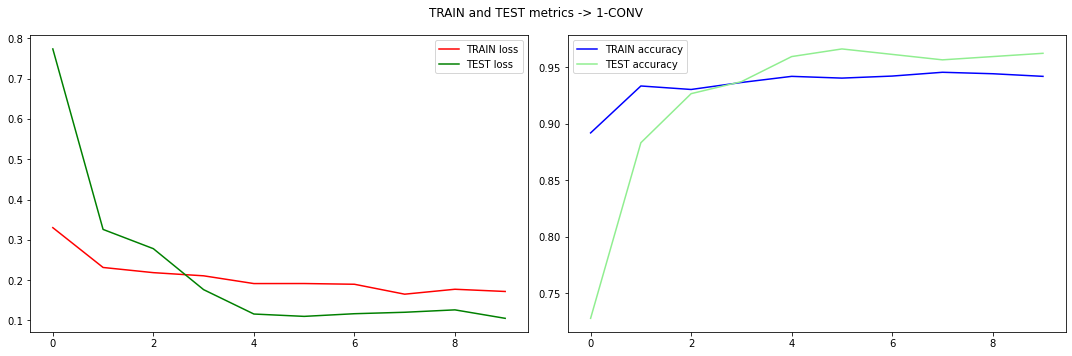

In [28]:
_, accuracy = advanced_model_2.evaluate(test_dataset, verbose=False)
print(f"SIMPLE CONV\nTEST accuracy: {accuracy}")
plot_learning_metrics(result, "1-CONV")

### Deep model without batch normalization

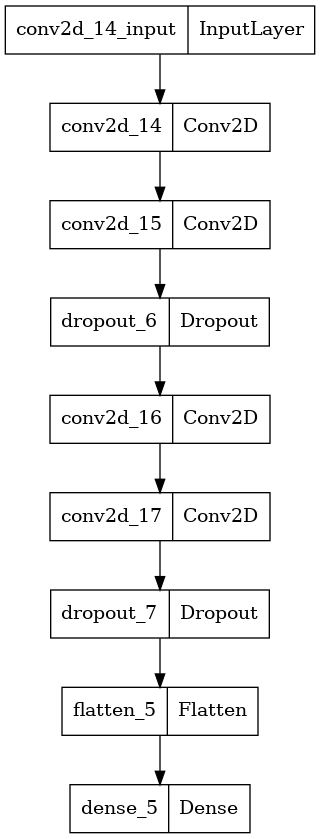

In [29]:
advanced_model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", input_shape=INPUT_SHAPE),
    
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=3, padding="same", activation="relu"),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=3, padding="same", activation="relu"),
    
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides = 3, padding="same", activation="relu"),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUT, activation="softmax")
])

advanced_model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                         optimizer=tf.keras.optimizers.Adam(), 
                         metrics=["accuracy"])

tf.keras.utils.plot_model(advanced_model_3)

In [30]:
result = advanced_model_3.fit(train_dataset, 
                              validation_data=validation_dataset, 
                              epochs=EPOCHS, 
                              batch_size=BATCH_SIZE)

Epoch 1/10
122/122 [==============================] - 5s 40ms/step - loss: 0.4682 - accuracy: 0.8328 - val_loss: 0.1707 - val_accuracy: 0.9479
Epoch 2/10
122/122 [==============================] - 5s 37ms/step - loss: 0.2440 - accuracy: 0.9314 - val_loss: 0.1590 - val_accuracy: 0.9575
Epoch 3/10
122/122 [==============================] - 5s 37ms/step - loss: 0.2278 - accuracy: 0.9329 - val_loss: 0.1417 - val_accuracy: 0.9537
Epoch 4/10
122/122 [==============================] - 4s 36ms/step - loss: 0.2180 - accuracy: 0.9293 - val_loss: 0.1367 - val_accuracy: 0.9546
Epoch 5/10
122/122 [==============================] - 4s 36ms/step - loss: 0.2188 - accuracy: 0.9342 - val_loss: 0.1513 - val_accuracy: 0.9508
Epoch 6/10
122/122 [==============================] - 5s 37ms/step - loss: 0.2031 - accuracy: 0.9383 - val_loss: 0.1310 - val_accuracy: 0.9566
Epoch 7/10
122/122 [==============================] - 4s 36ms/step - loss: 0.2047 - accuracy: 0.9355 - val_loss: 0.1348 - val_accuracy: 0.9556

SIMPLE CONV
TEST accuracy: 0.9505376219749451
Accuracy: 93.937% 



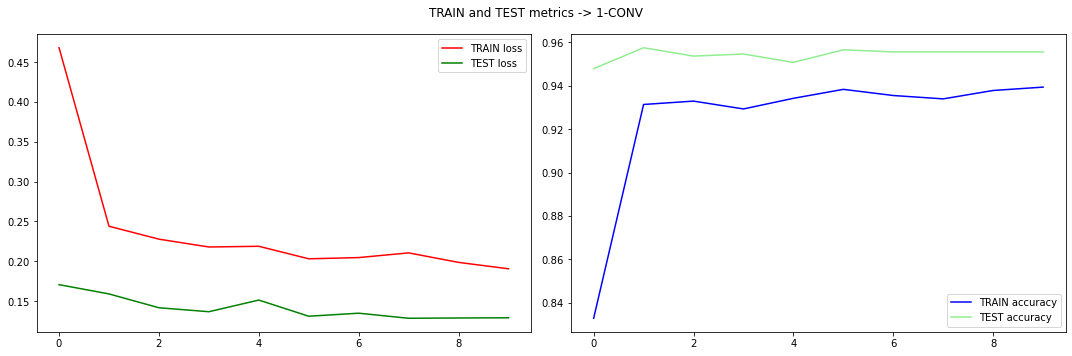

In [31]:
_, accuracy = advanced_model_3.evaluate(test_dataset, verbose=False)
print(f"SIMPLE CONV\nTEST accuracy: {accuracy}")
plot_learning_metrics(result, "1-CONV")

#### Conclusions
- Neural network with batch-normalization is a little better(~1%) than simple NN.
- NN without batch normalization is worse than simple NN with one layer

### Research of parameters
kernel-size, strides, padding

In [32]:
def build_model(kernel_size, strides, padding):
    advanced_model_2 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=kernel_size, activation="relu", padding="same", input_shape=INPUT_SHAPE),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(64, kernel_size=kernel_size, strides=strides, padding=padding, activation="relu"),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(64, kernel_size=kernel_size, strides = strides, padding=padding, activation="relu"),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(OUT, activation="softmax")
    ])

    advanced_model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                             optimizer=tf.keras.optimizers.Adam(), 
                             metrics=["accuracy"])
    
    return advanced_model_2

Kernel size: (2, 2)
Strides: 1
Padding: same, model accuracy *TEST* : 0.948387086391449
Accuracy: 94.092% 



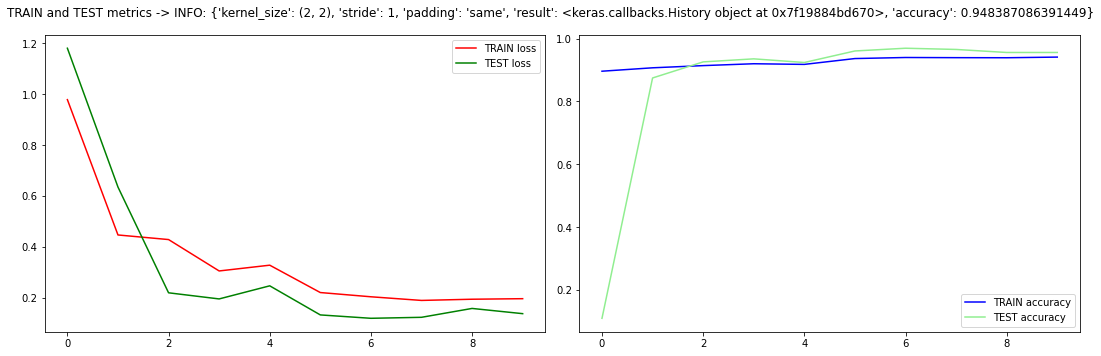

Padding: valid, model accuracy *TEST* : 0.9376344084739685
Accuracy: 93.989% 



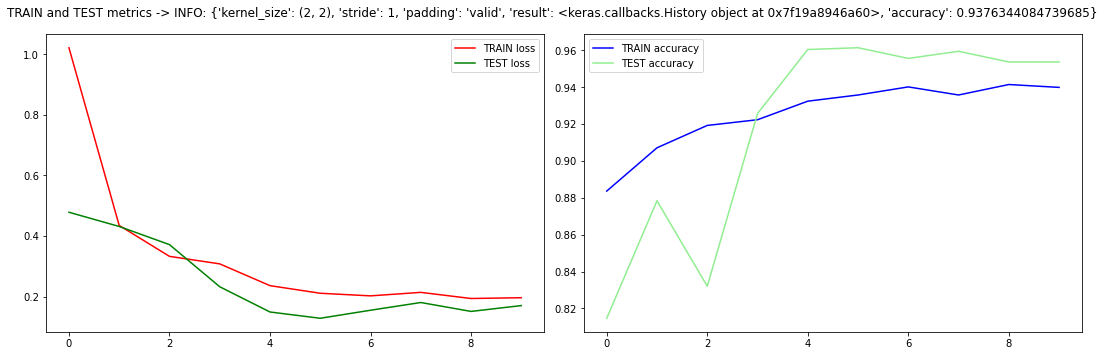

Strides: 2
Padding: same, model accuracy *TEST* : 0.9591397643089294
Accuracy: 93.782% 



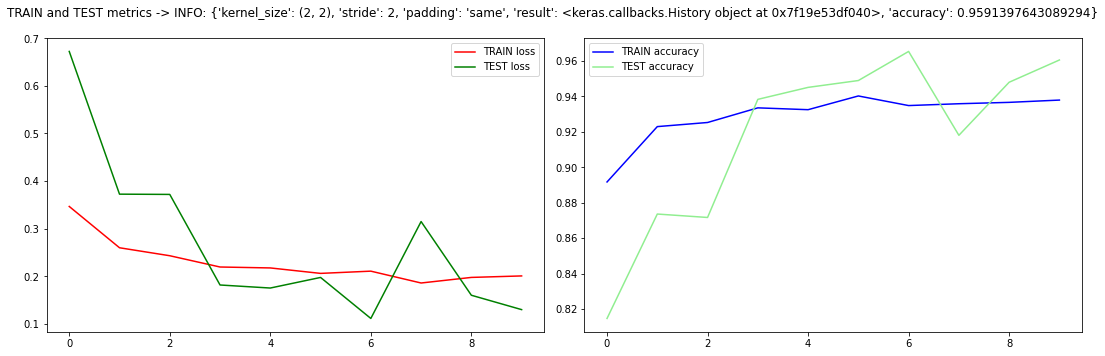

Padding: valid, model accuracy *TEST* : 0.9247311949729919
Accuracy: 94.298% 



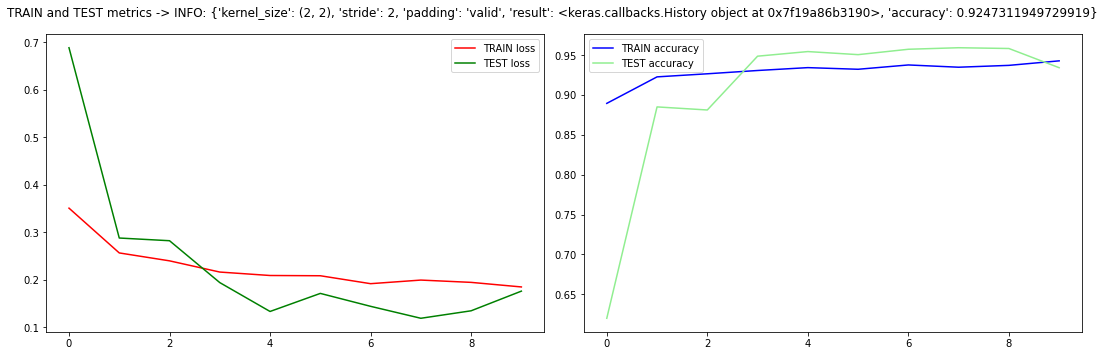

Strides: 3
Padding: same, model accuracy *TEST* : 0.9333333373069763
Accuracy: 90.015% 



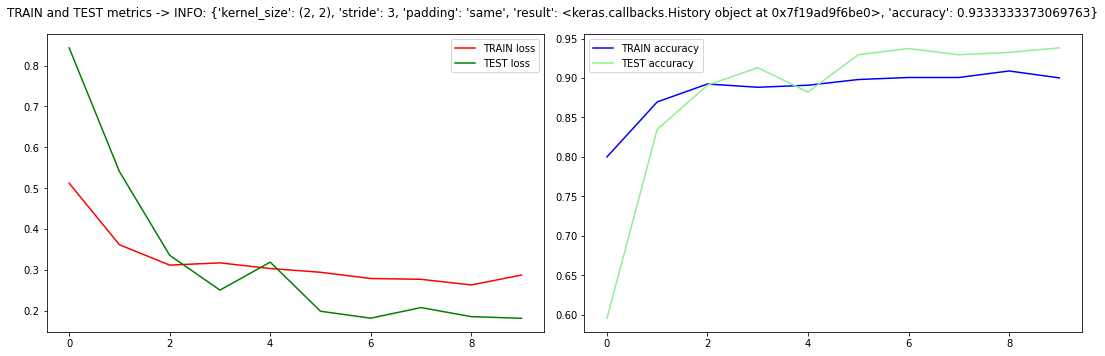

Padding: valid, model accuracy *TEST* : 0.8645161390304565
Accuracy: 84.675% 



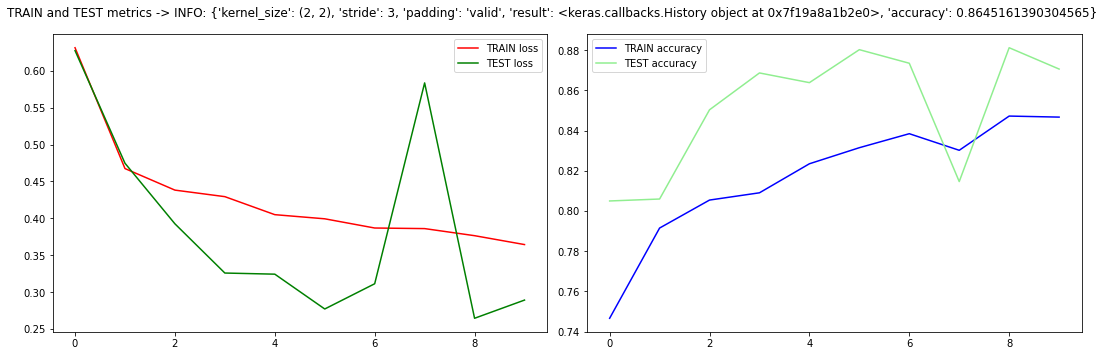

Strides: 5
Padding: same, model accuracy *TEST* : 0.8301075100898743
Accuracy: 85.217% 



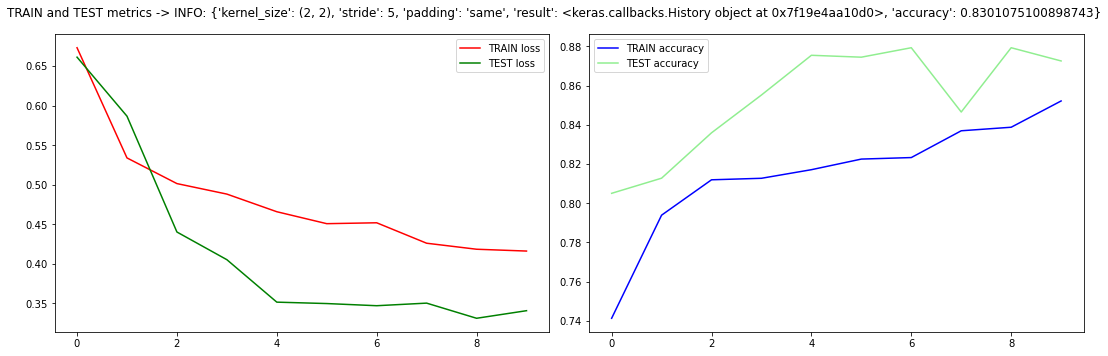

Padding: valid, model accuracy *TEST* : 0.8709677457809448
Accuracy: 84.907% 



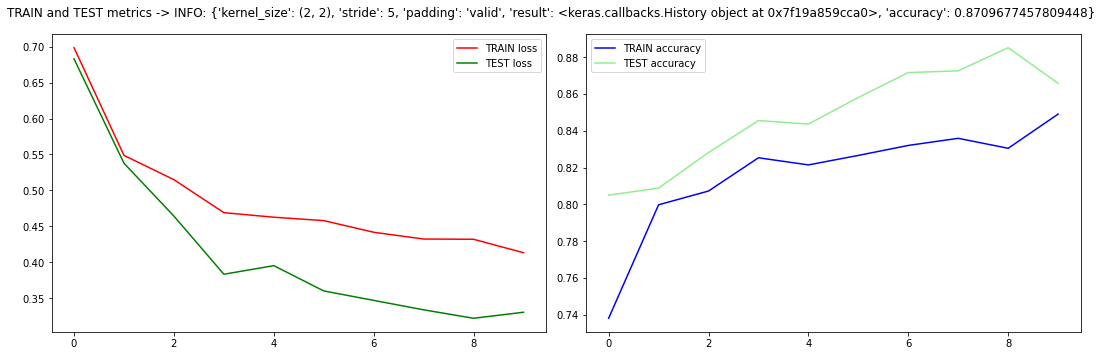

Kernel size: (3, 3)
Strides: 1
Padding: same, model accuracy *TEST* : 0.9548386931419373
Accuracy: 94.014% 



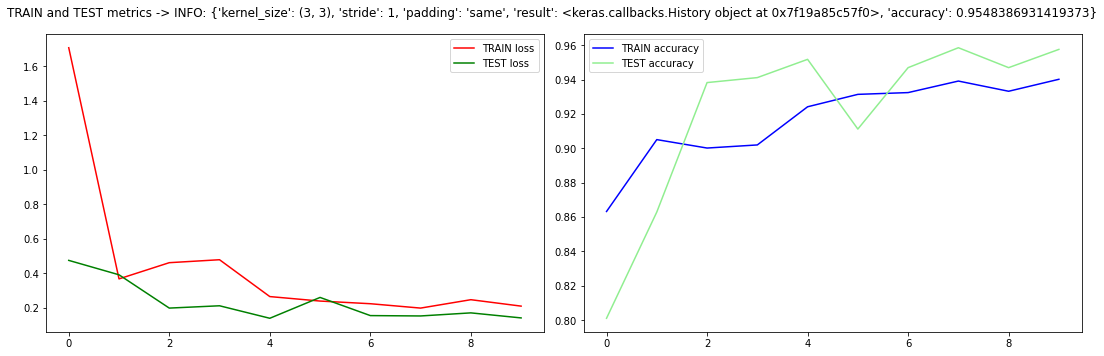

Padding: valid, model accuracy *TEST* : 0.9419354796409607
Accuracy: 92.982% 



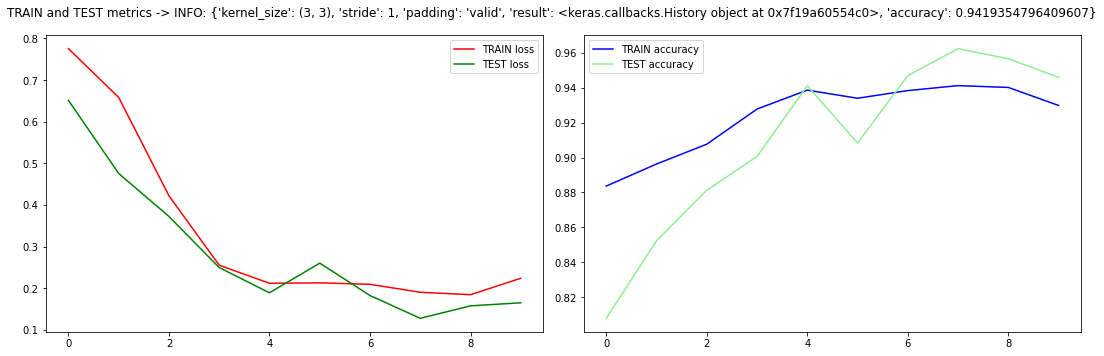

Strides: 2
Padding: same, model accuracy *TEST* : 0.9419354796409607
Accuracy: 94.298% 



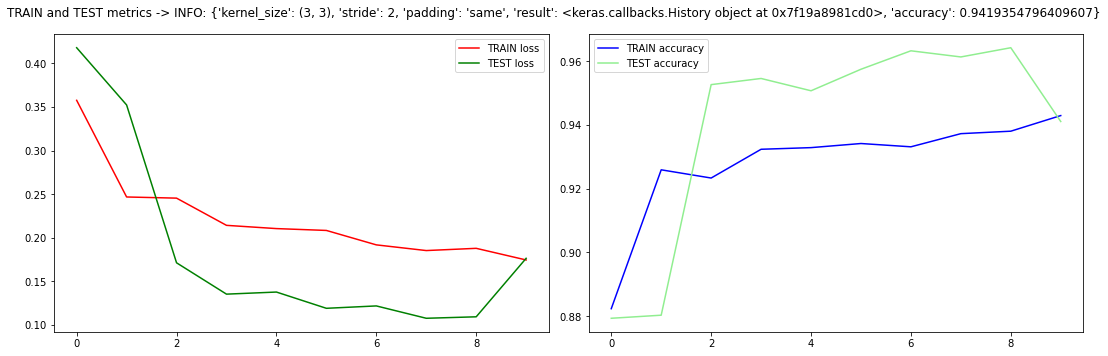

Padding: valid, model accuracy *TEST* : 0.9591397643089294
Accuracy: 94.118% 



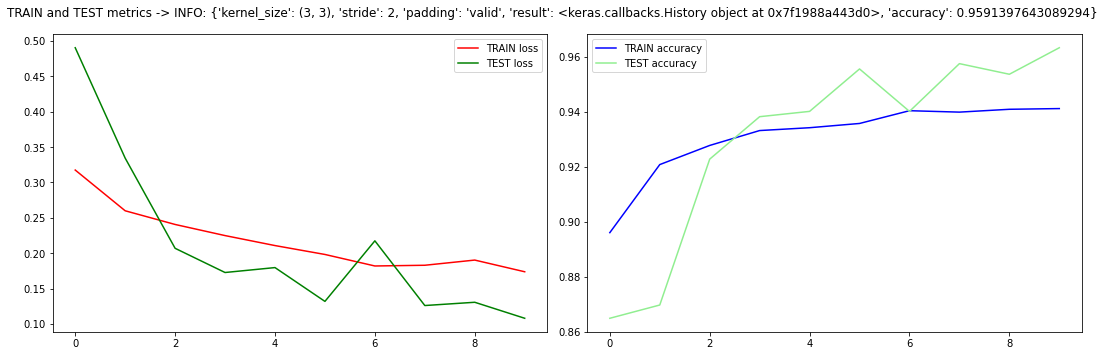

Strides: 3
Padding: same, model accuracy *TEST* : 0.9526881575584412
Accuracy: 94.53% 



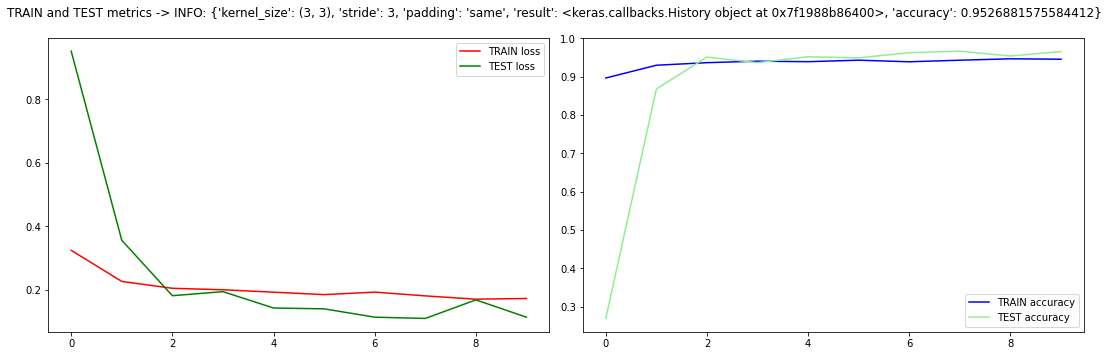

Padding: valid, model accuracy *TEST* : 0.9526881575584412
Accuracy: 94.298% 



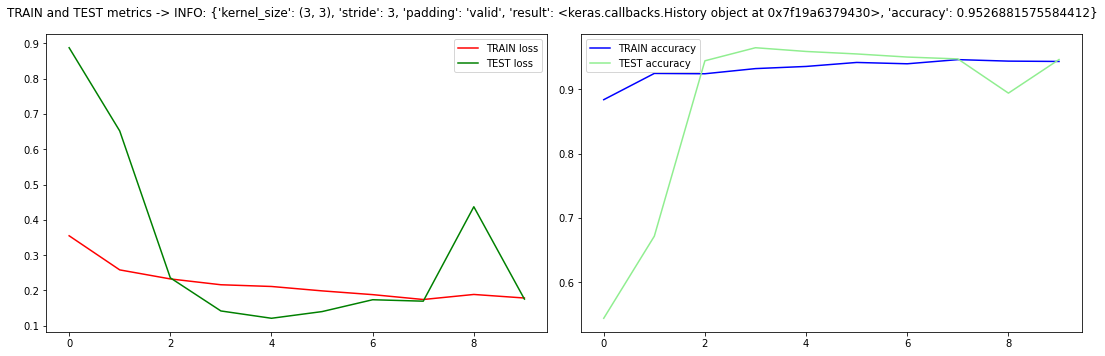

Strides: 5
Padding: same, model accuracy *TEST* : 0.9247311949729919
Accuracy: 91.95% 



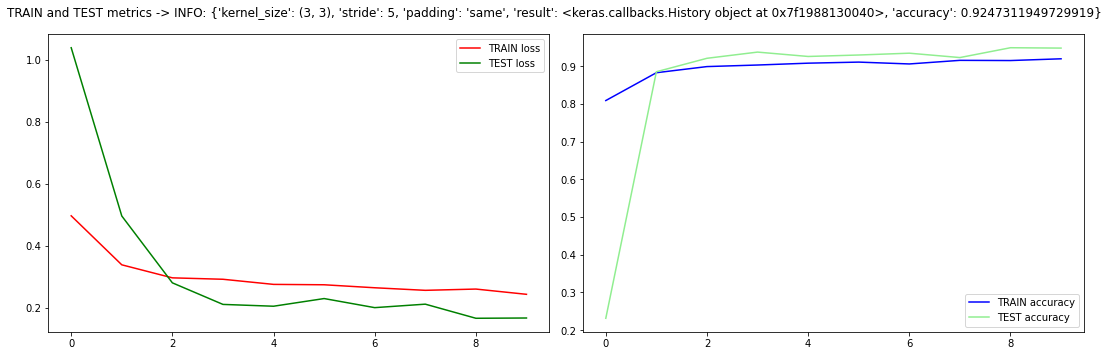

Negative dimension size
Kernel size: (4, 4)
Strides: 1
Padding: same, model accuracy *TEST* : 0.8430107235908508
Accuracy: 93.524% 



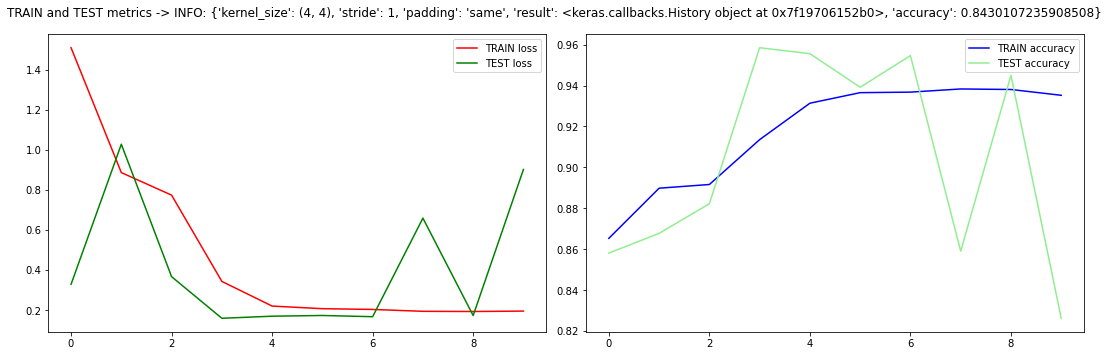

Padding: valid, model accuracy *TEST* : 0.9096774458885193
Accuracy: 93.524% 



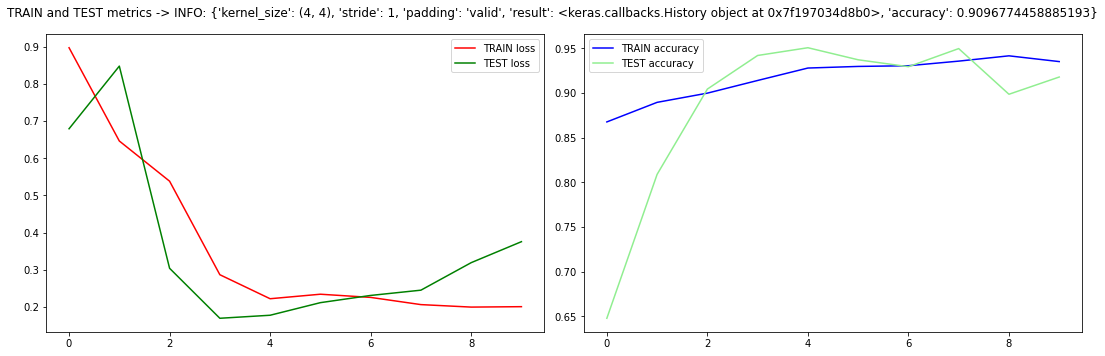

Strides: 2
Padding: same, model accuracy *TEST* : 0.9440860152244568
Accuracy: 94.118% 



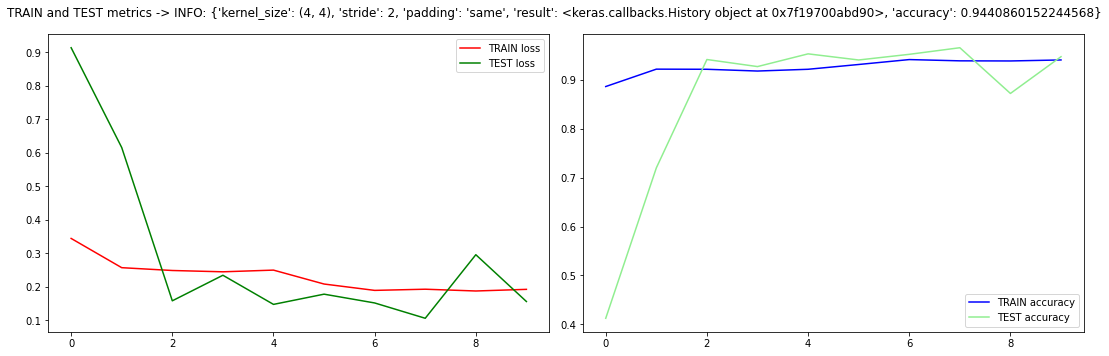

Padding: valid, model accuracy *TEST* : 0.9075269103050232
Accuracy: 94.247% 



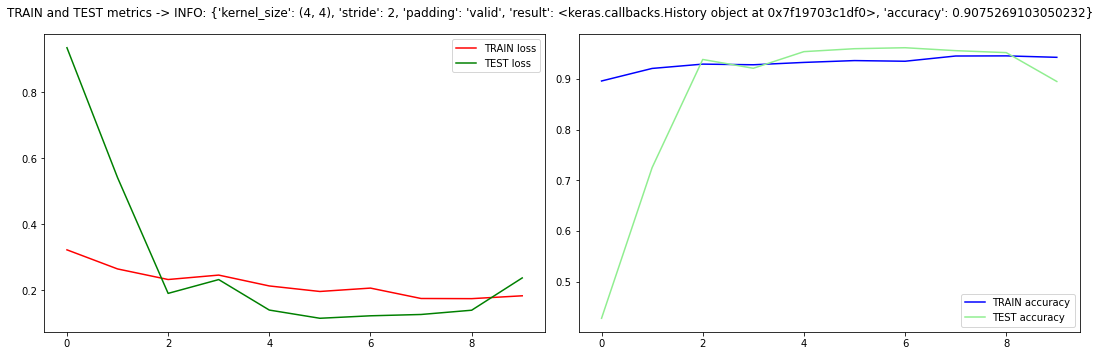

Strides: 3
Padding: same, model accuracy *TEST* : 0.926881730556488
Accuracy: 94.53% 



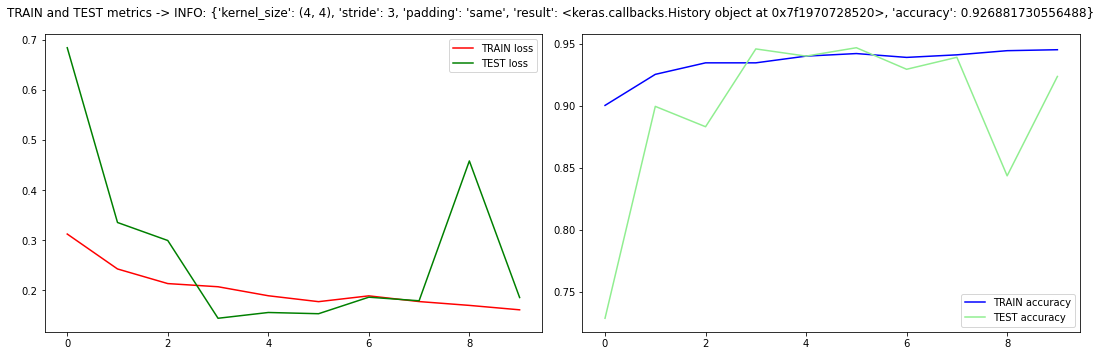

Negative dimension size
Strides: 5
Padding: same, model accuracy *TEST* : 0.8408601880073547
Accuracy: 93.705% 



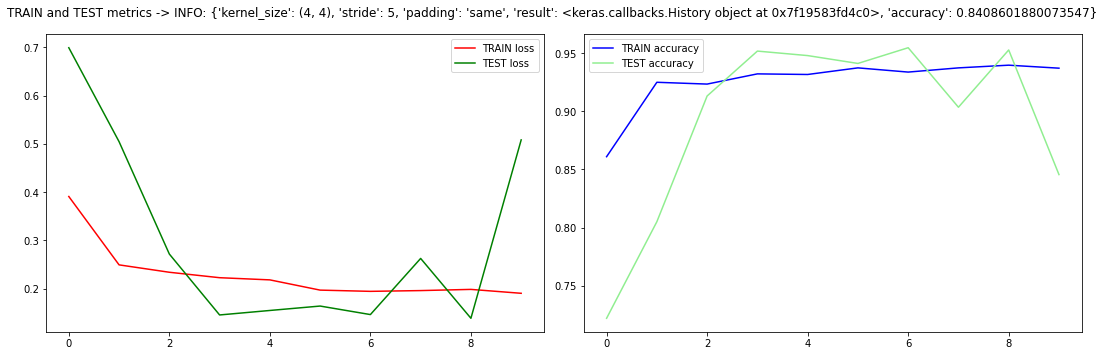

Negative dimension size
Kernel size: (5, 5)
Strides: 1
Padding: same, model accuracy *TEST* : 0.9032257795333862
Accuracy: 93.705% 



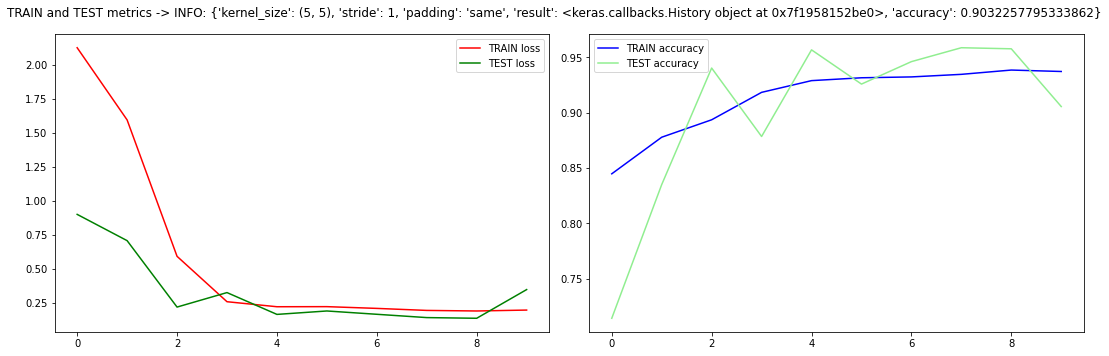

Padding: valid, model accuracy *TEST* : 0.9419354796409607
Accuracy: 93.369% 



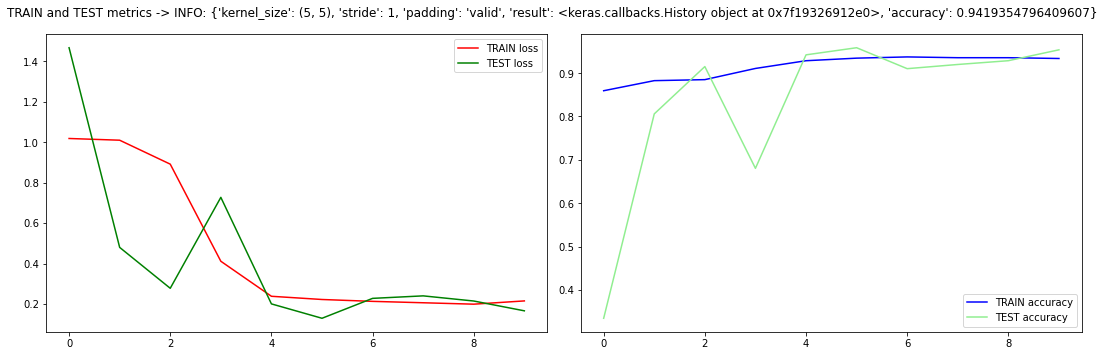

Strides: 2
Padding: same, model accuracy *TEST* : 0.9569892287254333
Accuracy: 94.221% 



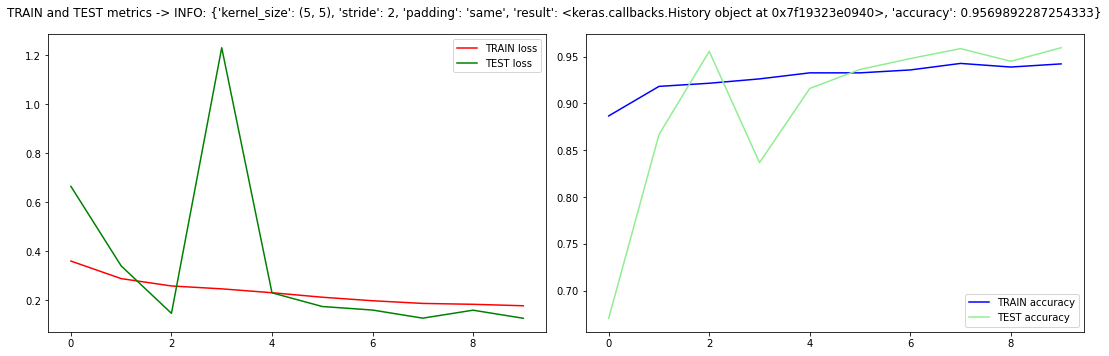

Padding: valid, model accuracy *TEST* : 0.9548386931419373
Accuracy: 94.118% 



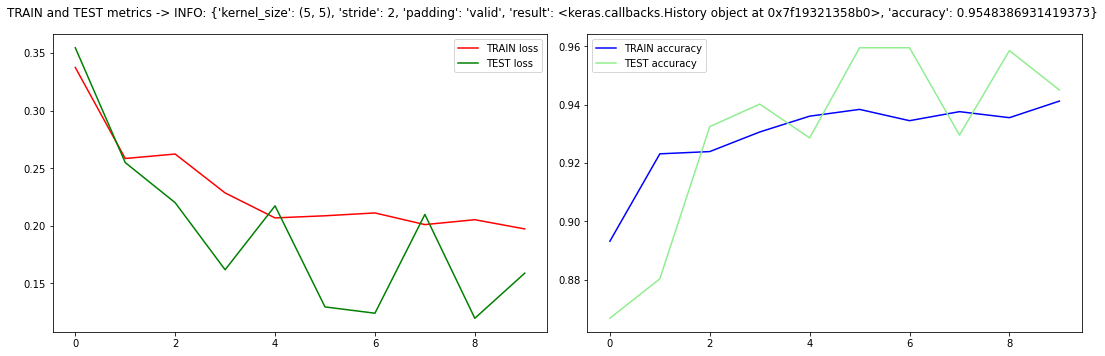

Strides: 3
Padding: same, model accuracy *TEST* : 0.9720430374145508
Accuracy: 94.969% 



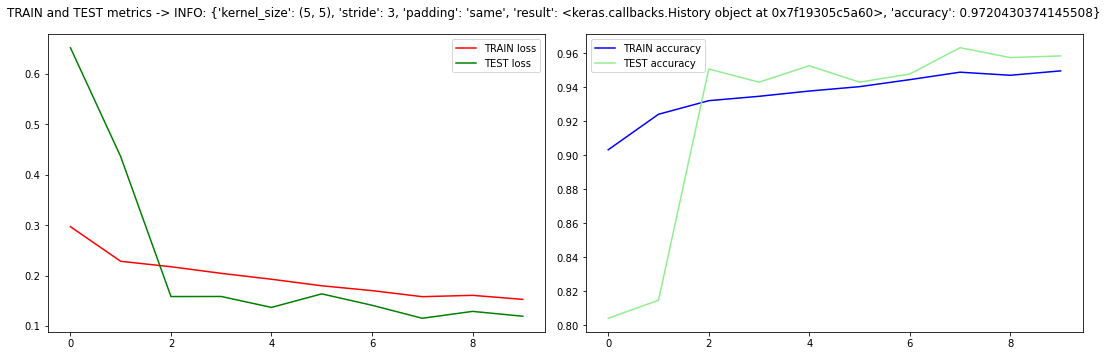

Negative dimension size
Strides: 5
Padding: same, model accuracy *TEST* : 0.9569892287254333
Accuracy: 94.427% 



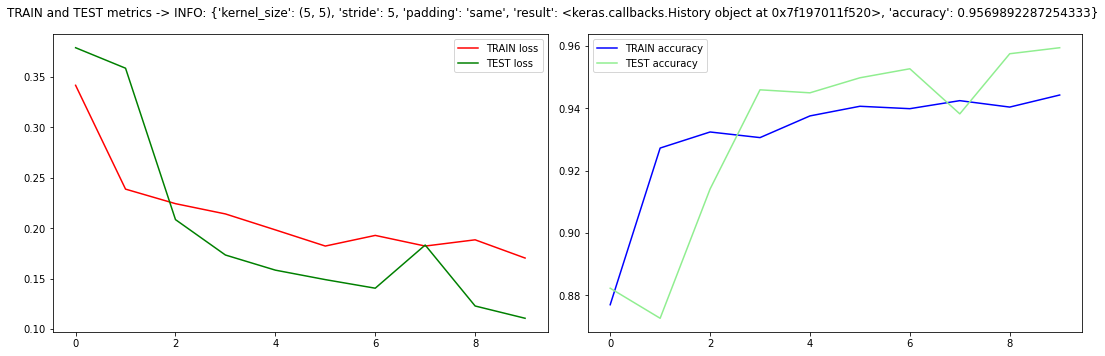

Negative dimension size


In [35]:
results = []
kernel_sizes = [(2,2), (3,3), (4,4), (5,5)]
strides = [1,2,3,5]
paddings = ["same", "valid"]

for kernel_size in kernel_sizes:
    print(f"Kernel size: {kernel_size}")
    for stride in strides:
        print(f"Strides: {stride}")
        for padding in paddings:
            try:
                model = build_model(kernel_size, stride, padding)
                
                result = model.fit(train_dataset,
                                   validation_data=validation_dataset, 
                                   epochs=EPOCHS, 
                                   batch_size=BATCH_SIZE,
                                   verbose=False)
                
                _, accuracy = model.evaluate(test_dataset, verbose=False)
                
                print(f"Padding: {padding}, model accuracy *TEST* : {accuracy}")
                results.append({
                    "kernel_size": kernel_size,
                    "stride": stride,
                    "padding": padding,
                    "result": result,
                    "accuracy": accuracy
                })
                plot_learning_metrics(result, f"INFO: {results[-1]}")
            except:
                print("Negative dimension size")
                pass

### Conclusions
- The best model is with kernel size (5, 5) stride = 3, padding = "valid". Accuracy on TEST dataset 97.2%
- Exception was raised while constructing model with kernel (5, 5), stride = 5 and padding= "valid". It can be caused by overfitting the kernel.
- The result of tuning kernel size, stride and padding is absolute arbitrary.
- Overfitting in most cases are absent

## Primary check

In [36]:
def check_mask(category_array):
    if category_array[0] == 1:
        print("Weared incorrect")
    elif category_array[1] == 1:
        print("Mask is present")
    elif category_array[2] == 1:
        print("Mask is absent")

In [85]:
best_model = build_model((3,3), 3, "valid")
                
result = best_model.fit(train_dataset,
                   validation_data=validation_dataset, 
                   epochs=EPOCHS, 
                   batch_size=BATCH_SIZE,
                   verbose=False)

_, accuracy = best_model.evaluate(test_dataset, verbose=False)  
print(f"Padding: {padding}, model accuracy *TEST* : {accuracy}")

Padding: valid, model accuracy *TEST* : 0.9569892287254333


In [142]:
best_model.summary()

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_247 (Conv2D)         (None, 35, 35, 32)        896       
                                                                 
 batch_normalization_180 (Ba  (None, 35, 35, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_248 (Conv2D)         (None, 11, 11, 32)        9248      
                                                                 
 batch_normalization_181 (Ba  (None, 11, 11, 32)       128       
 tchNormalization)                                               
                                                                 
 dropout_122 (Dropout)       (None, 11, 11, 32)        0         
                                                                 
 conv2d_249 (Conv2D)         (None, 3, 3, 64)        

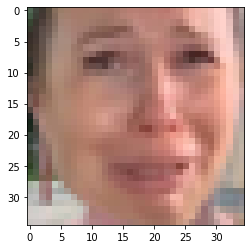

Mask is absent


array([0., 0., 1.], dtype=float32)

In [122]:
mask_test1_img = Image.open("./mask_dataset/custom_check/mask_test5.jpg").resize((35, 35))
mask_test1_img = np.array(mask_test1_img)

plt.imshow(mask_test1_img)
plt.show()

# best_model.predict(mask_test1_img[None,:,:])
# mask_test1_img.shape

prediction2 = advanced_model_3.predict(mask_test1_img[None,:,:])[0]
check_mask(prediction2)
prediction2

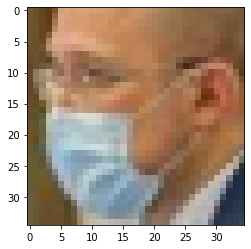

Mask is present


array([4.0379666e-21, 1.0000000e+00, 0.0000000e+00], dtype=float32)

In [123]:
mask_test1_img = Image.open("./mask_dataset/custom_check/mask_test13.jpg").resize((35, 35))
mask_test1_img = np.array(mask_test1_img)

plt.imshow(mask_test1_img)
plt.show()

# best_model.predict(mask_test1_img[None,:,:])
# mask_test1_img.shape

prediction2 = advanced_model_3.predict(mask_test1_img[None,:,:])[0]
check_mask(prediction2)
prediction2

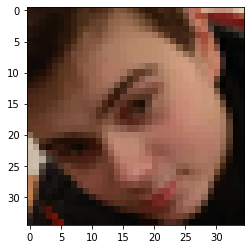

Mask is absent


array([7.4764317e-25, 1.4345431e-17, 1.0000000e+00], dtype=float32)

In [124]:
mask_test1_img = Image.open("./mask_dataset/custom_check/mask_test7.jpg").resize((35, 35))
mask_test1_img = np.array(mask_test1_img)

plt.imshow(mask_test1_img)
plt.show()

# best_model.predict(mask_test1_img[None,:,:])
# mask_test1_img.shape

prediction2 = advanced_model_3.predict(mask_test1_img[None,:,:])[0]
check_mask(prediction2)
prediction2

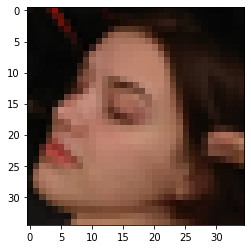

(35, 35, 3)
Mask is absent


array([2.0396697e-22, 1.1412438e-14, 1.0000000e+00], dtype=float32)

In [125]:
mask_test1_img = Image.open("./mask_dataset/custom_check/mask_test8.jpg").resize((35, 35))
mask_test1_img = np.array(mask_test1_img)

plt.imshow(mask_test1_img)
plt.show()

# best_model.predict(mask_test1_img[None,:,:])
print(mask_test1_img.shape)

prediction2 = advanced_model_3.predict(mask_test1_img[None,:,:])[0]
check_mask(prediction2)
prediction2

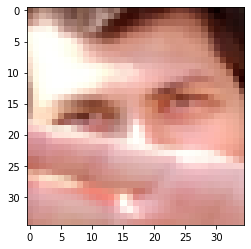

Mask is present


array([8.814044e-14, 1.000000e+00, 7.623953e-09], dtype=float32)

In [134]:
mask_test1_img = Image.open("./mask_dataset/custom_check/mask_test14.jpg").resize((35, 35))
mask_test1_img = np.array(mask_test1_img)

plt.imshow(mask_test1_img)
plt.show()

# best_model.predict(mask_test1_img[None,:,:])
# mask_test1_img.shape

prediction2 = advanced_model_3.predict(mask_test1_img[None,:,:])[0]
check_mask(prediction2)
prediction2

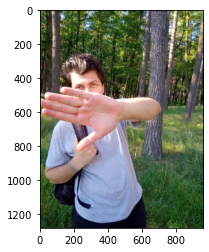

In [141]:
mask_test1_img = Image.open("./mask_dataset/custom_check/mask_test16.jpg")
mask_test1_img = np.array(mask_test1_img)

plt.imshow(mask_test1_img)
plt.show()

Якщо закрити лице камерою - працювати не буде